# Trackster-level graph net with PU

Question: does including the neighborhood provide a benefit over the pairwise classification?

In [1]:
import numpy as np
import torch
import sys

import torch.nn as nn
from torch.optim import SGD
from torch_cluster import knn_graph
from torch.optim.lr_scheduler import CosineAnnealingLR

from torch.utils.data import random_split
from torch_geometric.loader import DataLoader
import torch_geometric.transforms as T

from reco.model import DynamicEdgeConvBlock

from reco.training import precision_recall_curve, roc_auc
from reco.loss import GraphClassificationLoss
from reco.datasetPU import TracksterGraph


ds_name = "CloseByTwoPion"

data_root = "data"
raw_dir = f"/Users/ecuba/data/{ds_name}"

# data_root = "/mnt/ceph/users/ecuba/processed"
# raw_dir = f"/mnt/ceph/users/ecuba/{ds_name}"

In [2]:
# CUDA Setup
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [3]:
def create_mask(data):
    # extract the focus feature
    data.mask = (1 - data.x[:,0]).type(torch.bool)
    return data

def knn_transform(data):
    # pos coordinates are on position 3:6
    data.edge_index = knn_graph(data.pos, k=4, loop=False)
    return data

def prepend_pos(data):
    # GravNet: add S to the front
    data.x = torch.hstack((data.pos, data.x))
    return data

transforms = T.Compose([prepend_pos])

In [4]:
ds = TracksterGraph(
    ds_name,
    data_root,
    raw_dir,
    N_FILES=10,
    radius=100,
    bigT_e_th=75,
    # transform=transforms
    # pileup=True,
    # collection="CP"
)

# ds.processed_file_names
ds.data

Data(x=[51131, 39], y=[51131], pos=[51131, 3], e=[51131], shared_e=[51131], node_index=[51131])

In [5]:
len(ds.data.y)

51131

In [6]:
ds_size = len(ds)
test_set_size = ds_size // 10
train_set_size = ds_size - test_set_size
train_set, test_set = random_split(ds, [train_set_size, test_set_size])
print(f"Train graphs: {len(train_set)}, Test graphs: {len(test_set)}, total: {ds_size}")

train_dl = DataLoader(train_set, batch_size=16, shuffle=True)
test_dl = DataLoader(test_set, batch_size=16, shuffle=True)

Train graphs: 1431, Test graphs: 159, total: 1590


In [7]:
class TracksterGraphNet(nn.Module):
    def __init__(self, input_dim, output_dim=1, dropout=0.2, S=3):
        super(TracksterGraphNet, self).__init__()
        
        hdim1 = 64
        hdim2 = 64
        hdim3 = 64

        hdim_fc = 256

        self.edgeconv1 = DynamicEdgeConvBlock(input_dim, hdim1)
        self.edgeconv2 = DynamicEdgeConvBlock(hdim1, hdim2)
        self.edgeconv3 = DynamicEdgeConvBlock(hdim2, hdim3)
        
        # Edge features from node embeddings for classification        
        self.nodenetwork = nn.Sequential(
            nn.Linear(hdim3, hdim_fc),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hdim_fc, 3),
            nn.ReLU(),
            nn.Linear(3, output_dim),
            nn.Sigmoid()
        )

    def forward(self, X):
        H1 = self.edgeconv1(X)
        H2 = self.edgeconv2(H1)
        H3 = self.edgeconv3(H2)
        return self.nodenetwork(H3).squeeze(-1)

In [8]:
model = TracksterGraphNet(input_dim=ds.data.x.shape[1])
epochs = 10
model_path = f"models/TracksterGraphNet.GravNet.ns.{epochs}e-{ds_name}.{ds.RADIUS}.{ds.SCORE_THRESHOLD}.{ds.N_FILES}f.pt"

In [9]:
def train_graph_classification(model, device, optimizer, loss_func, train_dl):
    train_loss = []
    model.train()

    for data in train_dl:
        data = data.to(device)
        optimizer.zero_grad()

        seg_pred = model(data.x)
        loss = loss_func(data, seg_pred)
        loss.backward()

        optimizer.step()

        train_loss.append(loss.item())

    return np.mean(train_loss)

In [10]:
@torch.no_grad()
def test_graph_classification(model, device, loss_func, test_dl):
    test_loss = []
    model.eval()
    for data in test_dl:
        data = data.to(device)
        seg_pred = model(data.x)
        loss = loss_func(data, seg_pred)
        test_loss.append(loss.item())

    return np.mean(test_loss)

In [11]:
%%script echo skipping

# alpha - percentage of negative edges
loss_func = GraphClassificationLoss()

model = model.to(device)
optimizer = SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, epochs, eta_min=1e-5)

for epoch in range(epochs):

    train_loss = train_graph_classification(
        model,
        device,
        optimizer,
        loss_func,
        train_dl
    )
    
    scheduler.step()

    if epoch % 1 == 0:
        test_loss = test_graph_classification(model, device, loss_func, test_dl)
        print(
            f"Epoch {epoch}\t train loss: {train_loss:.3f}\t test loss: {test_loss:.3f}",
            file=sys.stderr
        )
        
torch.save(model.state_dict(), model_path)
print(model_path)

skipping


In [12]:
#%%script echo skipping
model.load_state_dict(torch.load(
    model_path,
    map_location=device
))
model = model.to(device)

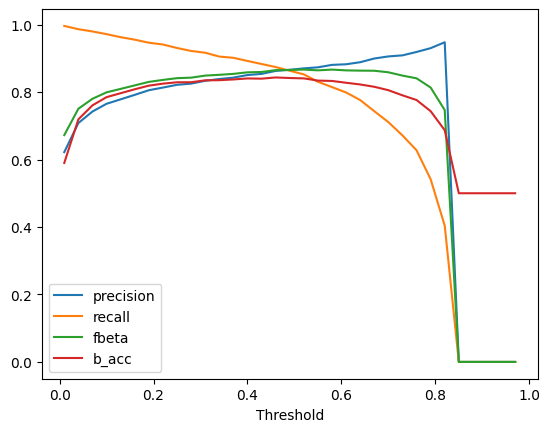

TP: 2553, TN: 1841, FP: 381, FN: 442
TH: 0.52 precision: 0.870 recall: 0.852 fbeta: 0.867 b_acc: 0.840


In [13]:
precision_recall_curve(model, device, test_dl, focus_metric="fbeta", beta=0.5, step=3, truth_threshold=0.5)

In [14]:
print(roc_auc(model, device, test_dl))

0.893341267294252


## Eval

In [15]:
import uproot
import matplotlib.pyplot as plt
import numpy as np
from reco.data import get_event_data
from reco.evaluation import model_evaluation

from reco.dummy import DummyPleaser

file_name = f"{raw_dir}/new_ntuples_15101852_0.root"
cluster_data, trackster_data, simtrackster_data, assoc_data = get_event_data(file_name)

In [16]:
result = model_evaluation(
    cluster_data,
    trackster_data,
    simtrackster_data,
    assoc_data,
    model,
    decision_th=0.5,
    radius=100,
    max_events=20,
    reco_to_target=False,
    bigT_e_th=75,
    graph=True,
)

Event 0:
[(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0), (10, 0), (11, 0), (12, 0), (13, 0), (14, 0), (15, 0), (16, 0), (17, 0), (18, 0), (19, 0), (20, 0), (21, 0), (22, 0), (23, 0), (24, 0), (25, 0), (26, 0), (27, 0), (28, 0), (29, 0), (30, 0), (31, 0), (32, 0), (33, 0), (34, 0), (35, 0), (0, 9), (1, 9), (2, 9), (3, 9), (4, 9), (5, 9), (6, 9), (7, 9), (8, 9), (9, 9), (10, 9), (11, 9), (12, 9), (13, 9), (14, 9), (15, 9), (16, 9), (17, 9), (18, 9), (19, 9), (20, 9), (21, 9), (22, 9), (23, 9), (24, 9), (25, 9), (26, 9), (27, 9), (28, 9), (29, 9), (30, 9), (31, 9), (32, 9), (33, 9), (34, 9), (35, 9), (36, 9), (37, 9), (38, 9), (39, 9), (40, 9), (0, 11), (1, 11), (2, 11), (3, 11), (4, 11), (5, 11), (6, 11), (7, 11), (8, 11), (9, 11), (10, 11), (11, 11), (12, 11), (13, 11), (14, 11), (15, 11), (16, 11), (17, 11), (18, 11), (19, 11), (20, 11), (21, 11), (22, 11), (23, 11), (24, 11), (25, 11), (26, 11), (27, 11), (28, 11), (29, 11), (30, 11), (31, 11), (32, 11

## Results

Using alpha=balance seems to converge faster (100 epochs rather than 200)
- maybe just sticking to 0.25? (works just fine)

Hyperparams
- (64, 128, noskip), alpha=balance, roc_auc = 0.9733
- (64, 128, 256fc, noskip, 200e), alpha=1-balance, roc_auc = 0.9771
- (64, 128, 256fc, noskip, 200e), alpha=balance, roc_auc = 0.981
- (64, 128, 256fc, noskip, 100e), alpha=0.25, roc_auc = 0.9796

In [17]:
import torch.onnx

onnx_filepath = f"onnx/TracksterGraphNet.mask.64.128.256.ns.{epochs}e-{ds_name}.{ds.RADIUS}.{ds.SCORE_THRESHOLD}.{ds.N_FILES}f.onnx"

torch.onnx.export(
    model,                          # model to be exported
    (ds[0].x),    # example input (add batch dimension)
    onnx_filepath,
    export_params=True,
    opset_version=11,
    do_constant_folding=True,
    input_names=['features'],      # the model's input names
    output_names=['output'],    # the model's output names
    dynamic_axes={              # variable length axes
        'features' : {0 : 'batch_size'},    
        'output' : {0 : 'batch_size'}
    }
)

UnsupportedOperatorError: ONNX export failed on an operator with unrecognized namespace torch_cluster::knn. If you are trying to export a custom operator, make sure you registered it with the right domain and version.